Disciplina : Inteligência Computacional 

Nome: Bruna Ferreira

Dataset: MNIST (“Instituto Nacional de Padrões e Tecnologia Modificado”)

Descrição: Contém imagens de dígitos escritos à mão. 

Objetivo: Construir um modelo que identifique corretamente os dígitos de um conjunto de dados de dezenas de milhares de dígitos escritos à mão.

Referencia : https://towardsdatascience.com/image-classification-in-10-minutes-with-mnist-dataset-54c35b77a38d

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
import seaborn as sns

### 0. Leitura Dados Mnist 

In [2]:
#Download banco de dados
import tensorflow as tf
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

## 0.1 Distribuição das Classes 

In [3]:
v1 = np.array(np.unique(y_train, return_counts=True)).T
v1 = pd.DataFrame(v1, columns = ["Digito", "Qtd_Instancias_Train"])
v2 = np.array(np.unique(y_test, return_counts=True)).T
v2 = pd.DataFrame(v2, columns = ["Digito", "Qtd_Instancias_Test"])

v1["Qtd_Instancias_Test"] = v2['Qtd_Instancias_Test']
v1['%Train'] = (v1['Qtd_Instancias_Train']/len(y_train))*100
v1['%Test'] = (v1['Qtd_Instancias_Test']/len(y_test))*100
v1

,Digito,Qtd_Instancias_Train,Qtd_Instancias_Test,%Train,%Test
0,0,5923,980,9.871667,9.80
1,1,6742,1135,11.236667,11.35
2,2,5958,1032,9.930000,10.32
3,3,6131,1010,10.218333,10.10
4,4,5842,982,9.736667,9.82
5,5,5421,892,9.035000,8.92
6,6,5918,958,9.863333,9.58
7,7,6265,1028,10.441667,10.28
8,8,5851,974,9.751667,9.74
9,9,5949,1009,9.915000,10.09


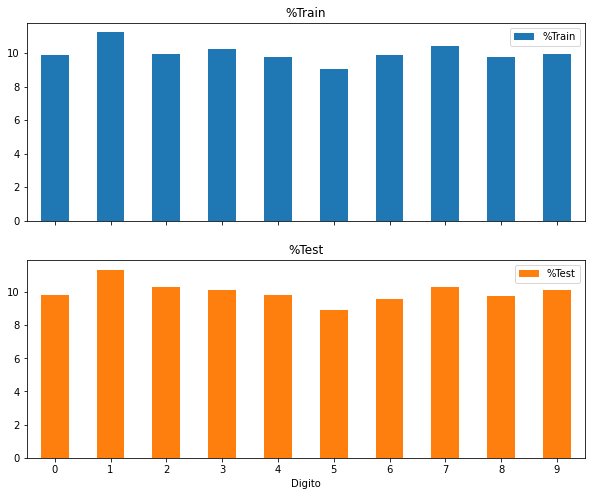

In [4]:
v = v1.reset_index()
v = v[["Digito","%Train","%Test"]]
v = v.set_index(["Digito"])
ax = v.plot.bar(rot=0, subplots=True,figsize=(10,8))

plt.show()

O banco de dados MNIST contém 60.000 imagens de treinamento e 10.000 imagens de teste obtidas de funcionários do American Census Bureau e estudantes americanos do ensino médio. 

As partes x_train e x_test contêm códigos RGB em tons de cinza (de 0 a 255), enquanto as partes y_train e y_test contêm rótulos de 0 a 9 que representam o número que realmente são. Para visualizar um dos exemplos.

8


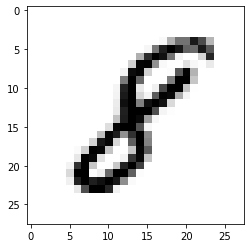

In [5]:
import matplotlib.pyplot as plt
#%matplotlib inline # Only use this if using iPython
image_index = 7777 # You may select anything up to 60,000
print(y_train[image_index]) # The label is 8
plt.imshow(x_train[image_index], cmap='Greys')

O método .shape retorna três itens : número de imagens no dataset, e tamanho da imagem: 28 x 28 pixels.

In [6]:
x_train.shape

(60000, 28, 28)

## 1. Normalização Imagens

Para poder usar o conjunto de dados na API Keras, é preciso que as matrizes NumPy tenham  4 dimensões. Porém o formato atual é 3-dim. 
Em modelos de rede neural, sempre é necessário normalizar os dados. Para isso basta dividir os códigos RGB em 255 (que é o código RGB máximo menos o código RGB mínimo). 

In [7]:
#Remodelar a matriz para 4-dim para que funcione com a API Keras
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
input_shape = (28, 28, 1)

# Certificando-se de que os valores são flutuantes para que possamos obter pontos decimais após a divisão
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# Normalizando os códigos RGB dividindo-os pelo valor RGB máximo.
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print('Number of images in x_train', x_train.shape[0])
print('Number of images in x_test', x_test.shape[0])

x_train shape: (60000, 28, 28, 1)
Number of images in x_train 60000
Number of images in x_test 10000


## 2. Construindo a Rede Neural Convolucional

Camadas Dropout lutam com o overfitting ao desconsiderar alguns dos neurônios durante o treinamento, enquanto as camadas Flatten achatam os arrays 2D em arrays 1D antes de construir as camadas totalmente conectadas.

* Número da primeira camada Densa: qualquer número
* Número de neuronios da camada de saida: obrigatoriamente 10, deve ter 10 neurônios, pois temos 10 classes de números (0, 1, 2, ..., 9). 
* Outros parametros variaveis : tamanho do kernel, tamanho do pool, funções de ativação, taxa de abandono e um número de neurônios na primeira camada Densa para obter um resultado melhor.


In [8]:
# Importing the required Keras modules containing model and layers
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D

In [9]:
# Creating a Sequential Model and adding the layers
model = Sequential()
model.add(Conv2D(28, kernel_size=(3,3), input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten()) # Flattening the 2D arrays for fully connected layers
model.add(Dense(128, activation=tf.nn.relu))
model.add(Dropout(0.2))
model.add(Dense(10,activation=tf.nn.softmax))

## 3. Compilando e ajustando o modelo
O código acima cria uma CNN vazia. 

Agora é preciso definir: 
- otimizador: com função de perda que usa uma métrica. 

Em seguida é possivel ajustar o modelo usando nossos dados de train. 


In [10]:
# # Garante a reproducividade do código
seed = 42
np.random.seed(seed)
epocas = 20
batch = 64

In [11]:
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

Conduct k-Fold Cross-Validation Using scikit-learn

In [15]:
# Create StratifiedKFold object. 
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1) 
score_stratified = [] 
   
for train_index, test_index in skf.split(x_train,y_train): 
    x_train_fold, x_test_fold = x_train[train_index],x_train[test_index] 
    y_train_fold, y_test_fold = y_train[train_index], y_train[test_index] 
    model.fit(x_train_fold, y_train_fold, batch_size=batch,epochs=epocas) 
    score_stratified.append(model.evaluate(x_test_fold, y_test_fold)) 
   

Epoch 1/20
844/844 [==============================] - 20s 24ms/step - loss: 0.0059 - accuracy: 0.9980
Epoch 2/20
844/844 [==============================] - 20s 24ms/step - loss: 0.0060 - accuracy: 0.9978
Epoch 3/20
844/844 [==============================] - 20s 24ms/step - loss: 0.0046 - accuracy: 0.9981
Epoch 4/20
844/844 [==============================] - 20s 24ms/step - loss: 0.0066 - accuracy: 0.9976
Epoch 5/20
844/844 [==============================] - 20s 24ms/step - loss: 0.0054 - accuracy: 0.9983
Epoch 6/20
844/844 [==============================] - 20s 24ms/step - loss: 0.0042 - accuracy: 0.9986
Epoch 7/20
844/844 [==============================] - 20s 24ms/step - loss: 0.0052 - accuracy: 0.9982
Epoch 8/20
844/844 [==============================] - 20s 24ms/step - loss: 0.0060 - accuracy: 0.9980
Epoch 9/20
844/844 [==============================] - 20s 24ms/step - loss: 0.0053 - accuracy: 0.9982
Epoch 10/20
844/844 [==============================] - 20s 24ms/step - loss: 0.007

É possivel variar:
-  otimizador
-  função de perda
-  métricas 
-  épocas. 

## 4. Avaliando o modelo 
Finalmente, você pode avaliar o modelo treinado com x_test e y_test usando uma linha de código:


In [16]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 2s 7ms/step - loss: 0.2321 - accuracy: 0.9854


[0.23205964267253876, 0.9854000210762024]

## 4.1 Matriz de Confusão

In [17]:
Ypred = model.predict(x_test)
Ypred = np.argmax(Ypred, axis=1)
Ypred

array([7, 2, 1, ..., 4, 5, 6])

In [18]:
y_test

array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)

In [21]:
cm = confusion_matrix(y_test, Ypred)

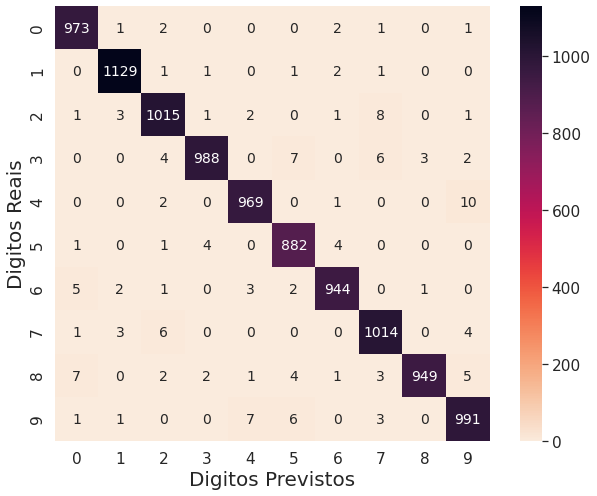

In [22]:
plt.figure(figsize=(11, 8))
sns.set(font_scale=1.4)
ax = sns.heatmap(cm,annot=True,fmt='g',annot_kws={'size':14} ,square=True,cmap='rocket_r')
ax.set_ylabel('Digitos Reais', fontsize=20)
ax.set_xlabel('Digitos Previstos', fontsize=20)
plt.show()

## 5. Prevendo um valor Especifico

9


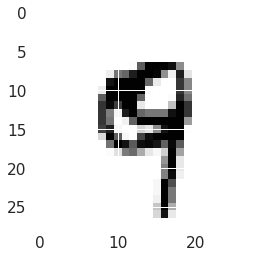

In [23]:
image_index = 4444
plt.imshow(x_test[image_index].reshape(28, 28),cmap='Greys')
pred = model.predict(x_test[image_index].reshape(1, 28, 28, 1))
print(pred.argmax())